In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Evaluation:
1. Evaluate on the pretrained models: download the pretrained model [here](https://drive.google.com/drive/folders/1G1GOA0FthtmOERJIJ0pALOSgXc6XOfoY) (credit: caiyuanhao)
2. Evaluate on the models retrained with Hyper-Skin data: 
3. Do step 1-2 for (RGB, VIS) data, and only step 2 for (MSI, NIR) data (reason, all pretrained model is based on input with in_channels = 3)
4. For all, compute the SSIM (for spatial evaluation) and SAM (for spectral evaluation)

In [2]:
import os 
import cv2 
import pickle
import spectral
import spectral.io.envi as envi
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torchvision import transforms
from torchmetrics import SpectralAngleMapper, StructuralSimilarityIndexMeasure

from hsiData import HyperSkinData
from utils import metrics 
from models.reconstruction import MST_Plus_Plus, HSCNN_Plus, hrnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_dir = 'E:/hyper-skin-data'
rgbvis_dir = f'{data_dir}/Hyper-Skin(RGB, VIS)'
mask_dir = f'{data_dir}/mask'
pretrained_dir  = 'pretrained-models/hyper-skin/vis'

# directories to the test data 
rgb_dir = f'{rgbvis_dir}/RGB_CIE/test'
vis_dir = f'{rgbvis_dir}/VIS/test'
mask_dir = f'{mask_dir}/test'

# directory to save the results
results_dir = 'E:/vis-nir-evaluation-results/pretrained-hyper-skin'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [4]:
test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
test_dataset = HyperSkinData.Load(
            hsi_dir = vis_dir,
            rgb_dir = rgb_dir, 
            transform = test_transform
    )
test_loader = torch.utils.data.DataLoader(
                                    dataset = test_dataset, 
                                    batch_size = 1, 
                                    shuffle = False,
                                    pin_memory = False)

1. Evaluation: HRNET (Pretrained on NTIRE)

In [5]:
# load the pretrained model from NTIRE 
model = HSCNN_Plus.HSCNN_Plus(in_channels=3, out_channels=31)
checkpoint = torch.load(f'{pretrained_dir}/hscnn')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
# load the pkl file
with open(f'{results_dir}/hscnn.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
model.to(device)
model.eval() 
# results = {
#     "file": [],
#     "pred": [],
#     "ssim_score": [],
#     "ssim_map": [],
#     "sam_score": [],
#     "sam_map": []
# }
metrics.ssim_fn.to(device)
for k, data in enumerate(test_loader):
    if k < 22:
        continue
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    with torch.no_grad():
        pred = model(x)

    ssim_score, ssim_map = metrics.ssim_fn(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results["pred"].append(pred.cpu().detach().numpy())
    results["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results["sam_score"].append(sam_score.cpu().detach().numpy())
    results["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results['file'][-1]}, SSIM: {results['ssim_score'][-1]}, SAM: {results['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/hscnn.pkl', 'wb') as f:
    pickle.dump(results, f)

Test [22/30]: p005_neutral_front, SSIM: 0.9184057116508484, SAM: 0.11321406066417694
Test [23/30]: p005_neutral_front, SSIM: 0.9186815619468689, SAM: 0.11757659912109375
Test [24/30]: p005_neutral_front, SSIM: 0.9264575839042664, SAM: 0.1265431046485901
Test [25/30]: p005_neutral_front, SSIM: 0.9252694845199585, SAM: 0.13527552783489227
Test [26/30]: p005_neutral_front, SSIM: 0.9102206826210022, SAM: 0.12744387984275818
Test [27/30]: p005_neutral_front, SSIM: 0.8684988617897034, SAM: 0.12781238555908203
Test [28/30]: p005_neutral_front, SSIM: 0.934662401676178, SAM: 0.13197915256023407
Test [29/30]: p005_neutral_front, SSIM: 0.9265991449356079, SAM: 0.1266625076532364


In [10]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9161 +/- 0.0131
SAM: 0.1190 +/- 0.0083


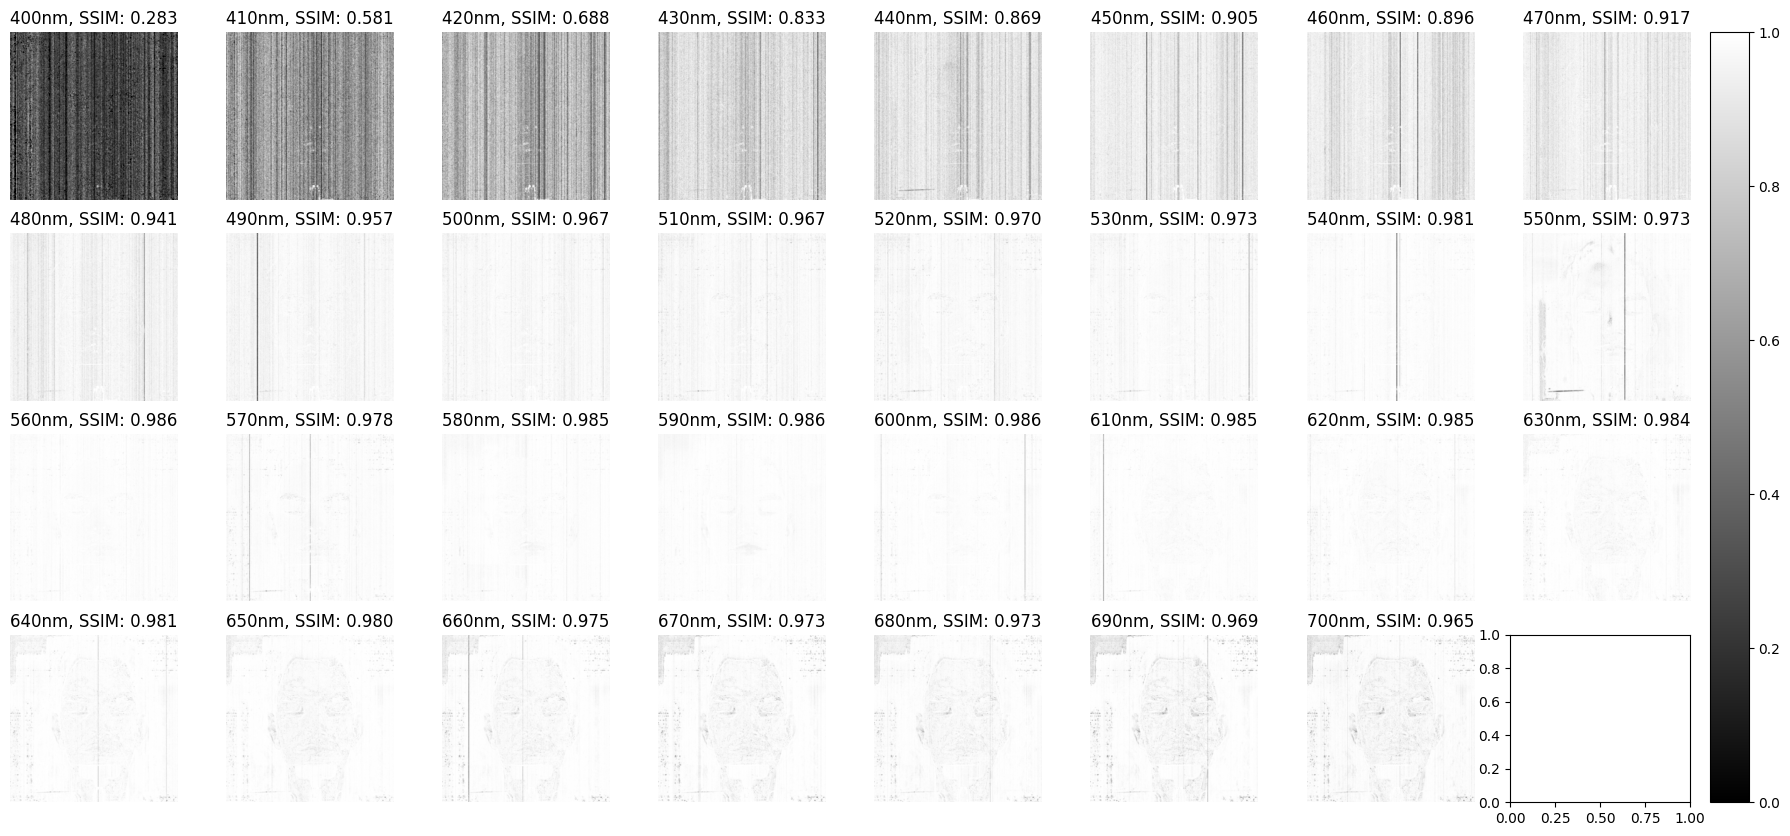

In [11]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(400, 710, 10)
ssim_map = np.array(results["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

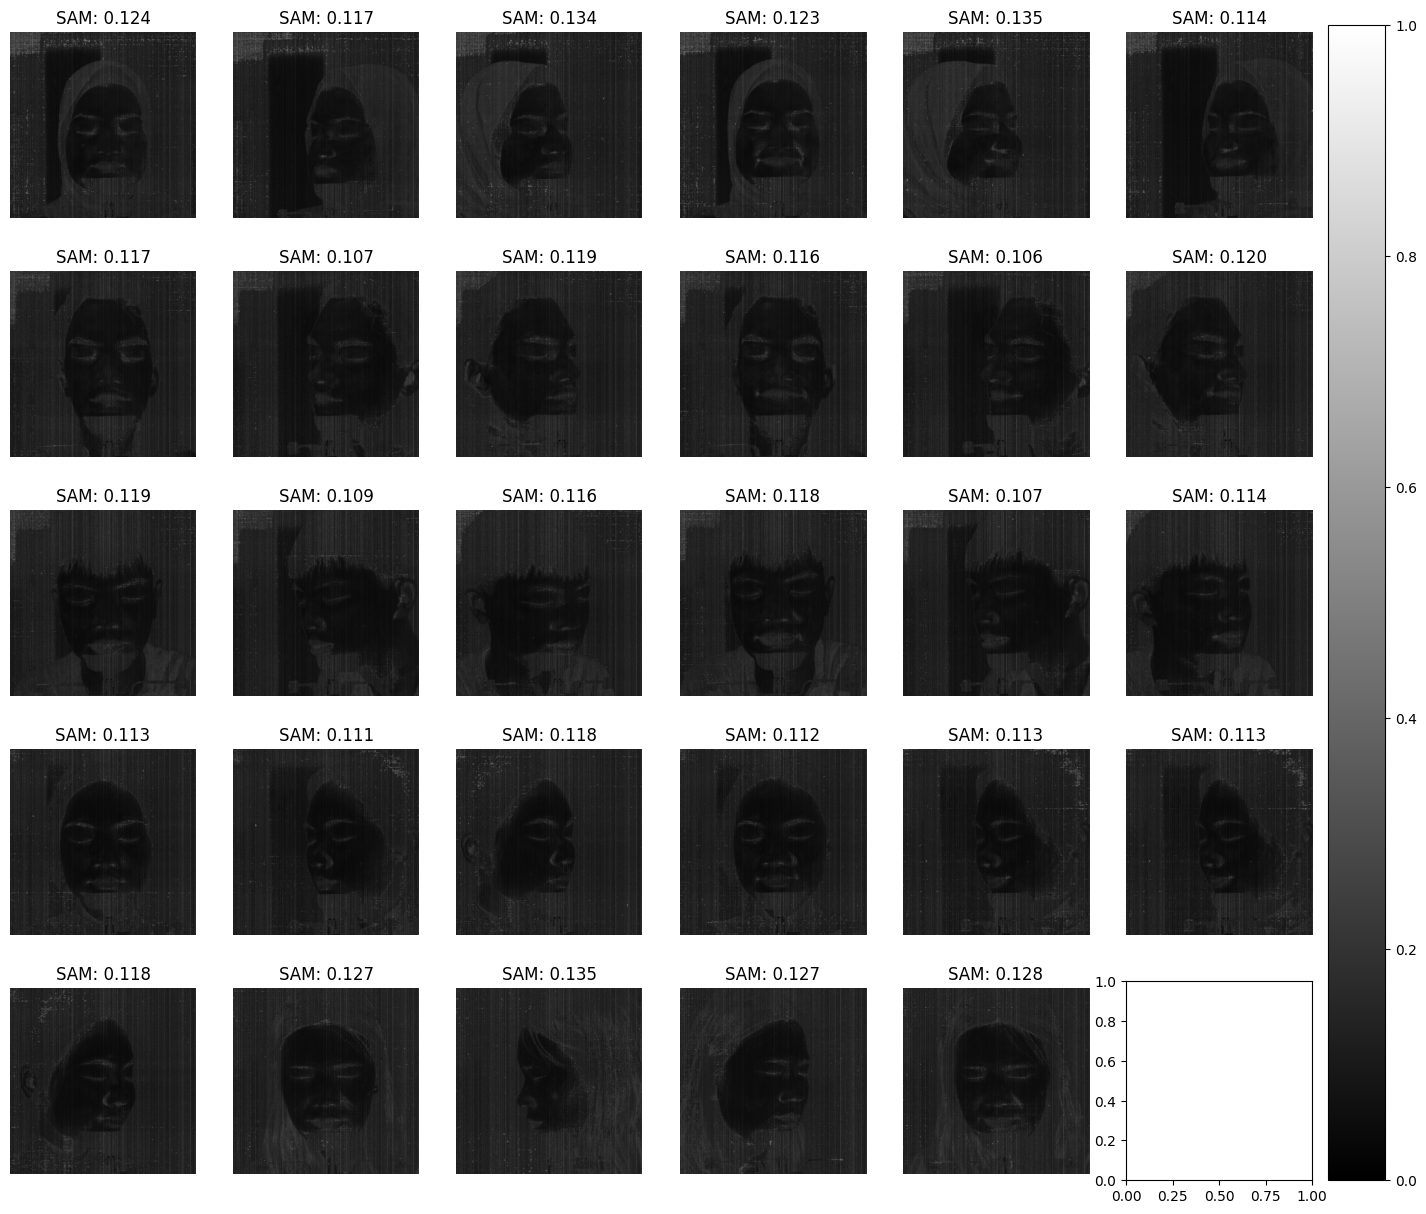

(31, 1024, 1024)

In [12]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [13]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

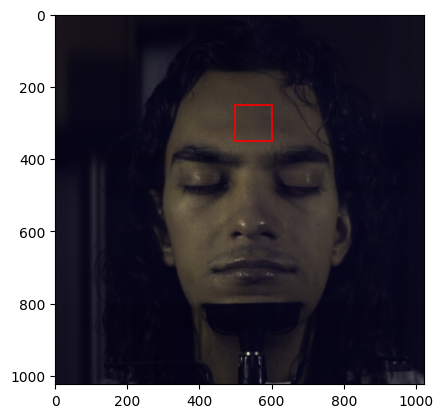

In [268]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

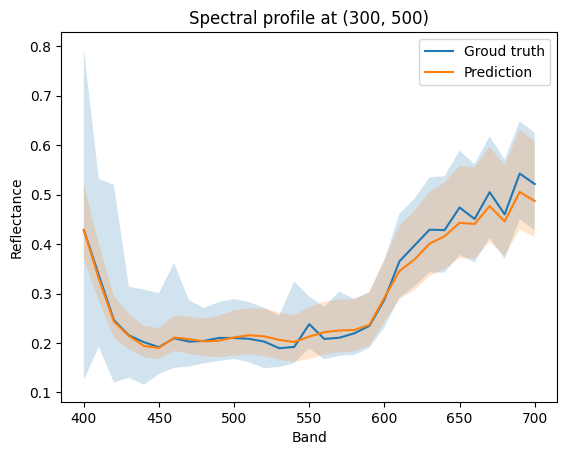

In [14]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()

1. only evaluate on the human subject - discard the background

In [6]:
# load the pkl file
with open(f'{results_dir}/masked_hscnn.pkl', 'rb') as f:
    results_m = pickle.load(f)

In [8]:
model.to(device)
model.eval() 
# results_m = {
#     "file": [],
#     "pred": [],
#     "ssim_score": [],
#     "ssim_map": [],
#     "sam_score": [],
#     "sam_map": []
# }
masks = sorted(os.listdir(mask_dir))
for k, data in enumerate(test_loader):
    if k < 14:
        continue
    x, y = data 
    x, y = x.float().to(device), y.float().to(device)

    mask = plt.imread(f"{mask_dir}/{masks[k]}")/255
    mask = torch.from_numpy(mask[:,:,0]).float().to(device)

    with torch.no_grad():
        pred = model(x)
        pred = pred * mask[None, None, ...]
        y = y * mask[None, None, ...]

    ssim_score, ssim_map = metrics.ssim_fn(pred, y)
    sam_score, sam_map = metrics.sam_fn(pred, y)

    results_m["file"].append(test_dataset.rgb_files[0].split('\\')[-1].split('.')[0])
    results_m["pred"].append(pred.cpu().detach().numpy())
    results_m["ssim_score"].append(ssim_score.cpu().detach().numpy())
    results_m["ssim_map"].append(ssim_map.cpu().detach().numpy())
    results_m["sam_score"].append(sam_score.cpu().detach().numpy())
    results_m["sam_map"].append(sam_map.cpu().detach().numpy())
    
    print(f"Test [{k}/{len(test_loader)}]: {results_m['file'][-1]}, SSIM: {results_m['ssim_score'][-1]}, SAM: {results_m['sam_score'][-1]}")    

# save the results in pickle format
with open(f'{results_dir}/masked_hscnn.pkl', 'wb') as f:
    pickle.dump(results_m, f)

Test [14/30]: p005_neutral_front, SSIM: 0.9388651251792908, SAM: 0.11070185899734497
Test [15/30]: p005_neutral_front, SSIM: 0.9411131143569946, SAM: 0.11149381101131439
Test [16/30]: p005_neutral_front, SSIM: 0.9522556662559509, SAM: 0.10187919437885284
Test [17/30]: p005_neutral_front, SSIM: 0.9396219849586487, SAM: 0.10761681944131851
Test [18/30]: p005_neutral_front, SSIM: 0.9521098732948303, SAM: 0.1037718653678894
Test [19/30]: p005_neutral_front, SSIM: 0.9546980261802673, SAM: 0.10708708316087723
Test [20/30]: p005_neutral_front, SSIM: 0.9509648680686951, SAM: 0.1095053106546402
Test [21/30]: p005_neutral_front, SSIM: 0.9587448239326477, SAM: 0.10194524377584457
Test [22/30]: p005_neutral_front, SSIM: 0.9525915384292603, SAM: 0.11148589104413986
Test [23/30]: p005_neutral_front, SSIM: 0.9500774145126343, SAM: 0.10971245169639587
Test [24/30]: p005_neutral_front, SSIM: 0.9484376907348633, SAM: 0.12188322097063065
Test [25/30]: p005_neutral_front, SSIM: 0.9467542171478271, SAM: 0.

In [9]:
# compute the mean and std of the SSIM and SAM scores
ssim_scores = np.array(results_m["ssim_score"])
ssim_mean = np.mean(ssim_scores)
ssim_std = np.std(ssim_scores)

sam_scores = np.array(results_m["sam_score"])
sam_mean = np.mean(sam_scores)
sam_std = np.std(sam_scores)
print(f"SSIM: {ssim_mean:.4f} +/- {ssim_std:.4f}")
print(f"SAM: {sam_mean:.4f} +/- {sam_std:.4f}")

SSIM: 0.9499 +/- 0.0108
SAM: 0.1134 +/- 0.0093


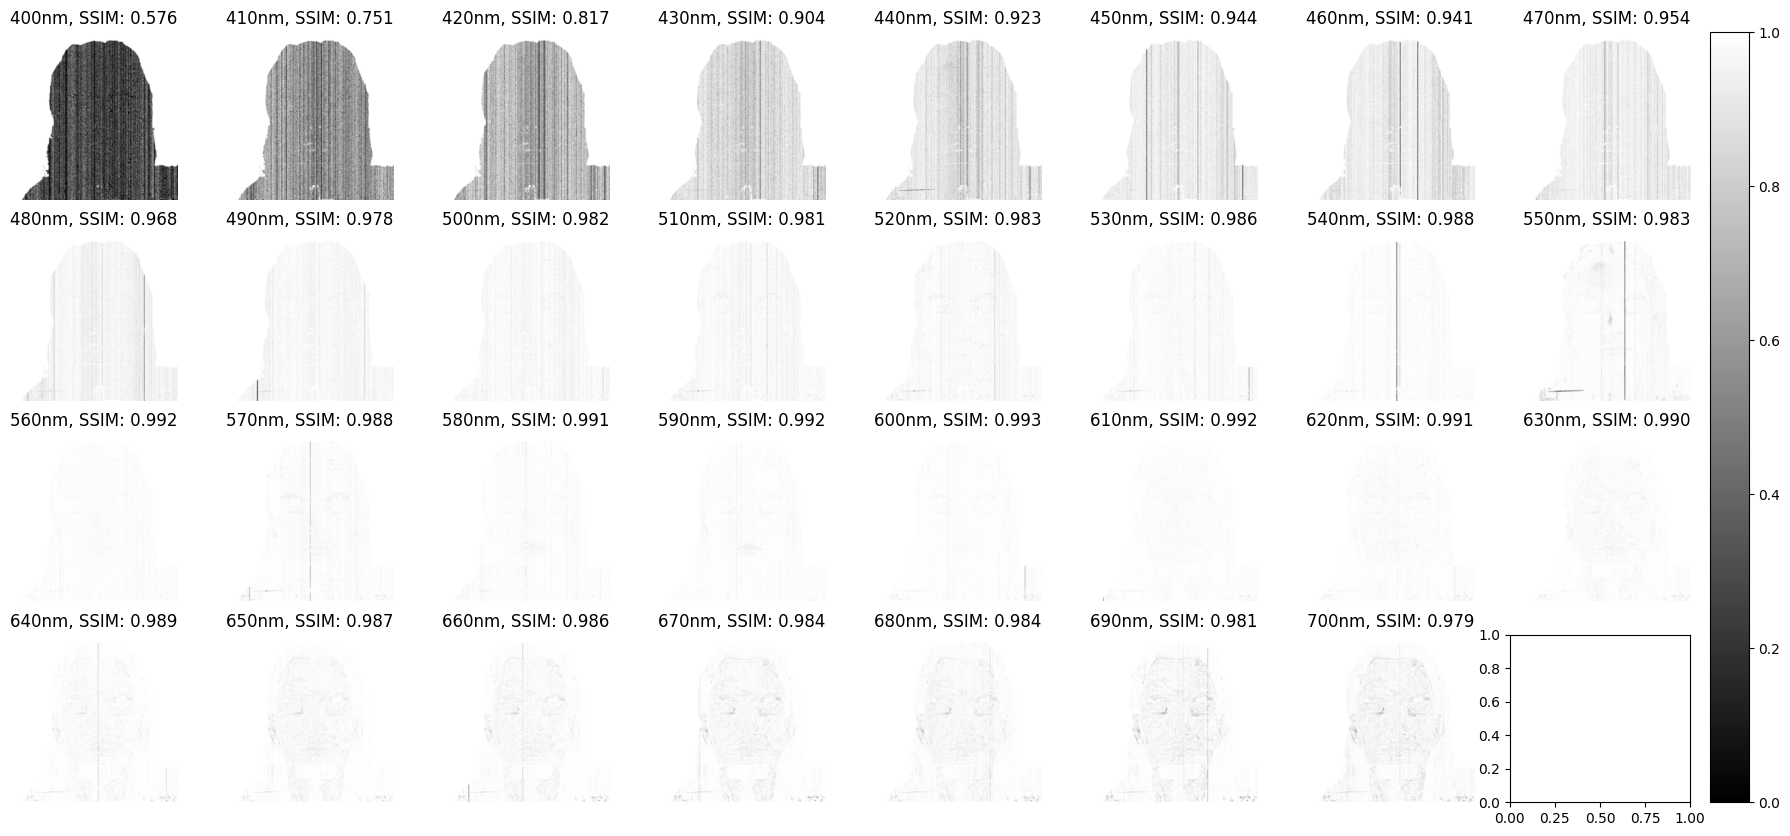

In [10]:
# visualize the ssim map for 31 bands to understand which band has better ssim score
band_31 = np.arange(400, 710, 10)
ssim_map = np.array(results_m["ssim_map"]).squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(26, 10))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(ssim_map[6, i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"{band_31[i]}nm, SSIM: {ssim_map[6, i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()

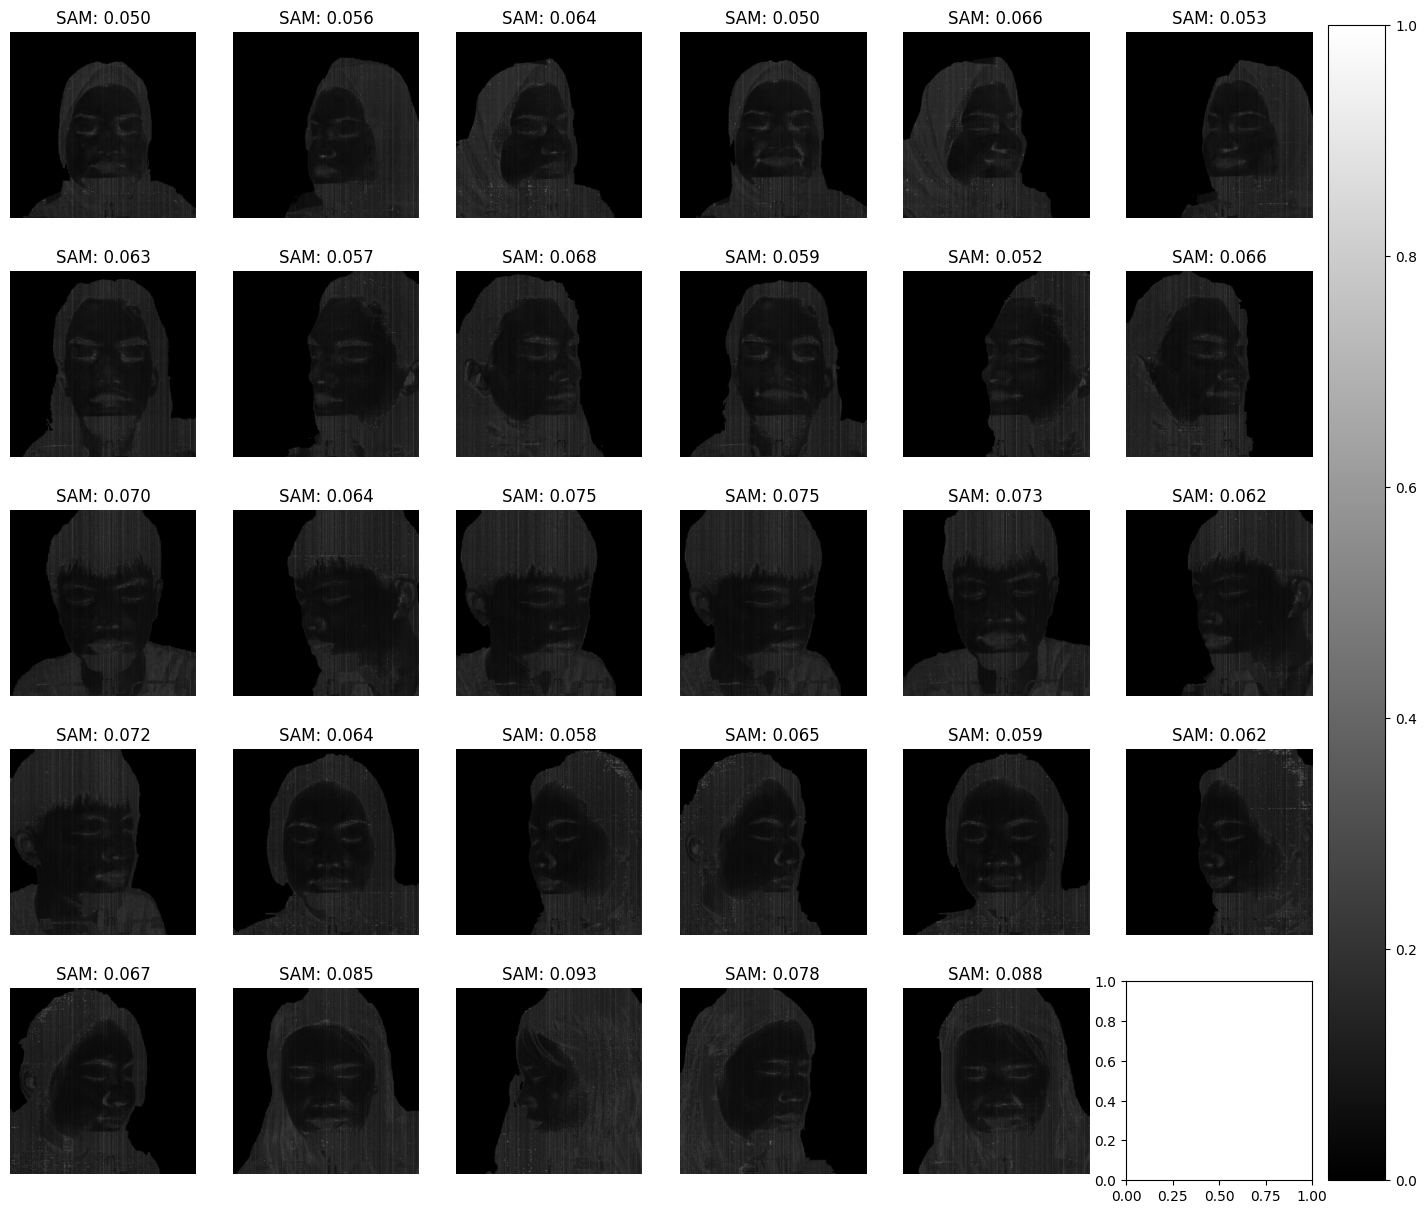

(31, 1024, 1024)

In [11]:
# visualize the sam map for 31 bands to understand which band has better ssim score
sam_map = np.array(results_m["sam_map"]).squeeze()
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(axes.flat[:-1]):
    im = ax.imshow(sam_map[i, :, :], vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    ax.set_title(f"SAM: {sam_map[i, :, :].mean():.3f}")
fig.colorbar(im, ax=axes.ravel().tolist(), pad = 0.01)
plt.show()
sam_map.shape

In [12]:
h, w, hwsize = 250, 500, 100
x, y = test_dataset[6]
y = y.numpy()
p = np.array(results_m["pred"]).squeeze()[6]

yy = y[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
yy_median = np.median(yy, axis=1)
yy_max = yy.max(1)
yy_min = yy.min(1)
pp = p[:, h:h+hwsize, w:w+hwsize].reshape(-1, 10000)
pp_median = np.median(pp, axis=1)
pp_max = pp.max(1)
pp_min = pp.min(1)

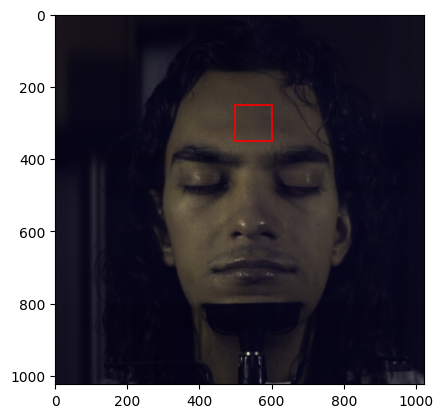

In [13]:
plt.imshow(x.permute(1, 2, 0).numpy())

# Add the patch to the Axes
plt.gca().add_patch(Rectangle((w,h),hwsize,hwsize,linewidth=1.2,edgecolor='r',facecolor='none'))

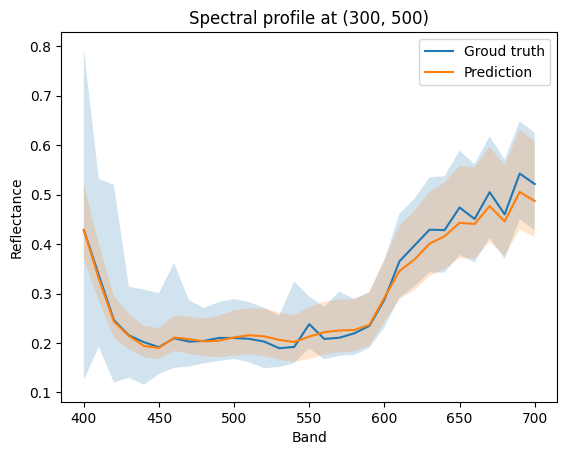

In [14]:
plt.plot(band_31, yy_median, label='Groud truth')
plt.fill_between(band_31, yy_min, yy_max, alpha=0.2)
plt.plot(band_31, pp_median, label='Prediction')
plt.fill_between(band_31, pp_min, pp_max, alpha=0.2)
plt.title('Spectral profile at (300, 500)')
plt.legend()
plt.ylabel('Reflectance')
plt.xlabel('Band')
plt.show()